In [1]:
import csv
import pandas as pd
from datetime import datetime
from Levenshtein import distance as levenshtein_distance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
from fitter import Fitter
import itertools
import multiprocessing
import statsmodels.api as sm

In [2]:
events_final = pd.read_csv('truncated_events_final_threeday.csv') 
print(events_final)

       patientid             events            starttime
0       10002013              CSURG  2160-05-18 01:49:32
1       10002013                ABG  2160-05-18 09:19:00
2       10002013            Calcium  2160-05-18 09:19:00
3       10002013            Glucose  2160-05-18 09:19:00
4       10002013                CBC  2160-05-18 09:19:00
...          ...                ...                  ...
96243   19995790         Creatinine  2185-02-04 04:45:00
96244   19995790            Glucose  2185-02-04 04:45:00
96245   19995790         Metoprolol  2185-02-04 20:00:00
96246   19995790                 SW  2185-02-05 01:00:00
96247   19995790  Magnesium Sulfate  2185-02-05 01:00:00

[96248 rows x 3 columns]


In [3]:

events_final['starttime'] = pd.to_datetime(events_final['starttime'])

In the next step, we will start to generat the trace

In [4]:

traces = events_final.groupby('patientid')['events'].apply(list).reset_index()
traces['starttimes'] = events_final.groupby('patientid')['starttime'].apply(list).reset_index(drop=True)

In [5]:
print(traces.head())
traces.to_csv('traces.csv', index=False)

   patientid                                             events  \
0   10002013  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
1   10011398  [CSURG, ABG, Electrolytes, CBC, Glucose, Calci...   
2   10023771  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
3   10033786  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   
4   10039688  [CSURG, ABG, Calcium, Glucose, CBC, Electrolyt...   

                                          starttimes  
0  [2160-05-18 01:49:32, 2160-05-18 09:19:00, 216...  
1  [2146-12-15 04:53:55, 2146-12-15 07:52:00, 214...  
2  [2113-08-25 03:17:43, 2113-08-25 07:29:00, 211...  
3  [2118-01-16 06:35:16, 2118-01-16 12:00:00, 211...  
4  [2147-05-31 02:31:44, 2147-05-31 07:57:00, 214...  


In [6]:
print(traces['events'].dtype)

object


In [7]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])

['CSURG', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'Electrolytes', 'ABG', 'CBC', 'Glucose', 'Aspirin', 'ABG', 'Glucose', 'CBC', 'Electrolytes', 'Acetaminophen', 'Nitroglycerin', 'Sterile Water', 'Neostigmine', 'Opioid', 'Influenza Vaccine', 'Potassium Chloride', 'Dextrose 50%', 'Magnesium Sulfate', 'PHENYLEPHrine', 'Milk of Magnesia', 'Sodium Chloride 0.9%  Flush', 'Oxycodone-Acetaminophen', '5% Dextrose', 'Pneumococcal Vaccine', 'Glycopyrrolate', 'Metoclopramide', 'Insulin', 'Propofol', 'Sodium Chloride 0.9%', 'Calcium Gluconate', 'Lactated Ringers', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'CBC', 'Sodium Chloride 0.9%', 'CefazoLIN', 'CBC', 'Urea Nitrogen', 'Electrolytes', 'Creatinine', 'Bicarbonate', 'ABG', 'Calcium', 'Glucose', 'Electrolytes', 'ABG', 'Electrolytes', 'Calcium', 'Glucose', 'Ketorolac', 'ABG', 'Glucose', 'Electrolytes', 'Electrolytes', 'CBC', 'Ondansetron', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Albumin', 'Li

In [8]:
def calculate_hamming_distance(list1, list2, pad_value=None):

    max_len = max(len(list1), len(list2))
    list1_padded = list1 + [pad_value] * (max_len - len(list1))
    list2_padded = list2 + [pad_value] * (max_len - len(list2))
    

    distance = sum(el1 != el2 for el1, el2 in zip(list1_padded, list2_padded))
    return distance

In [9]:

list1 = ['A','B','C','D']
list2 =['A','C','D']


hamming_distance_example = calculate_hamming_distance(list1, list2, pad_value='')
print(f"Hamming distance between list1 and list2: {hamming_distance_example}")

levenshtein_distance_example = levenshtein_distance(list1, list2)
print(f"levenshtein distance between list1 and list2: {levenshtein_distance_example}")

Hamming distance between list1 and list2: 3
levenshtein distance between list1 and list2: 1


In [10]:
first_line = traces.iloc[1]['events']
second_line = traces.iloc[2]['events']
print(traces.iloc[1]['events'])
print(traces.iloc[2]['events'])
print(len(traces.iloc[1]['events']))
print(len(traces.iloc[2]['events']))
hamming_distance_1_2 = calculate_hamming_distance(first_line, second_line)
levenshtein_distance_1_2 = levenshtein_distance(first_line, second_line)
print(f"Hamming distance between the first and second lines: {hamming_distance_1_2}")
print(f"Levenshtein distance between the first and second lines: {levenshtein_distance_1_2}")

['CSURG', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'Electrolytes', 'ABG', 'CBC', 'Glucose', 'Aspirin', 'ABG', 'Glucose', 'CBC', 'Electrolytes', 'Acetaminophen', 'Nitroglycerin', 'Sterile Water', 'Neostigmine', 'Opioid', 'Influenza Vaccine', 'Potassium Chloride', 'Dextrose 50%', 'Magnesium Sulfate', 'PHENYLEPHrine', 'Milk of Magnesia', 'Sodium Chloride 0.9%  Flush', 'Oxycodone-Acetaminophen', '5% Dextrose', 'Pneumococcal Vaccine', 'Glycopyrrolate', 'Metoclopramide', 'Insulin', 'Propofol', 'Sodium Chloride 0.9%', 'Calcium Gluconate', 'Lactated Ringers', 'ABG', 'Electrolytes', 'CBC', 'Glucose', 'Calcium', 'CBC', 'Sodium Chloride 0.9%', 'CefazoLIN', 'CBC', 'Urea Nitrogen', 'Electrolytes', 'Creatinine', 'Bicarbonate', 'ABG', 'Calcium', 'Glucose', 'Electrolytes', 'ABG', 'Electrolytes', 'Calcium', 'Glucose', 'Ketorolac', 'ABG', 'Glucose', 'Electrolytes', 'Electrolytes', 'CBC', 'Ondansetron', 'Chlorhexidine Gluconate 0.12% Oral Rinse', 'Docusate Sodium', 'Ranitidine', 'Albumin', 'Li

In [11]:
num_elements = len(traces)
hamming_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))
for i in range(num_elements):
    for j in range(num_elements):
        hamming_distance = calculate_hamming_distance(traces.at[i, "events"], traces.at[j, "events"])
        hamming_distance_matrix.at[i, j] = hamming_distance

print(hamming_distance_matrix)

     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
0      0  108  106  103  105  109  107  114  112  106  ...  109  109  111   
1    108    0  111  103  107  104  106   94  102  113  ...  109   98  105   
2    106  111    0  109  106  112  117  114  109  102  ...  116  109  113   
3    103  103  109    0  103  110  101  105  100  117  ...  118  105   97   
4    105  107  106  103    0  110  105  100  106  114  ...  115  101  106   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
842  113  110  114  116  113  108  109  109  108  110  ...  116  115  109   
843  112  103  111  105  105  106  105  107  103  111  ...  115  107  109   
844  116  106  112  104  106  112  105  105   90  111  ...  119   97   96   
845  117  108  117  109  106  115  113  107   94  120  ...  122  105  108   
846  113   96  112  106  107  108  105   95   96  111  ...  113   93   99   

     840  841  842  843  844  845  846  
0    115  118  113  112  116  117 

In [12]:

hamming_row_averages = hamming_distance_matrix.mean(axis=1)
print("Hamming row averages:")
print(hamming_row_averages)

Hamming row averages:
0      114.913813
1      110.498229
2      115.302243
3      111.617473
4      110.775679
          ...    
842    116.904368
843    113.155844
844    107.903188
845    111.263282
846    108.438017
Length: 847, dtype: object


In [13]:

hamming_sorted_row_averages = hamming_row_averages.sort_values(ascending=False)
hamming_reordered_matrix = hamming_distance_matrix.loc[hamming_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(hamming_sorted_row_averages)

print("Reordered Hamming distance matrix:")
print(hamming_reordered_matrix)

Sorted row averages (descending):
333    202.540732
80      177.85242
460    169.716647
395    168.768595
52      167.27863
          ...    
340    106.710744
148     106.70366
563    106.695396
627    106.642267
516    106.396694
Length: 847, dtype: object
Reordered Hamming distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  197  203  193  200  196  203  202  201  202  205  ...  198  206  204   
80   176  179  175  178  179  180  180  181  182  179  ...  177  180  182   
460  171  172  170  172  171  171  169  169  171  172  ...  168  170  172   
395  170  169  171  166  174  171  167  170  163  171  ...  171  166  167   
52   167  164  165  170  162  167  173  171  172  171  ...  165  164  169   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
340  106  103  105  104  103  113  109   98   88  112  ...  110   97  105   
148  108  102  104  101  101  112  109  103   94  119  ...  115  100  102   
563  105  102

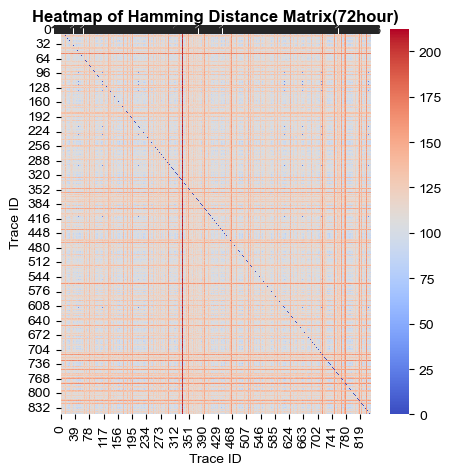

In [14]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Hamming Distance Matrix(72hour)', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure1_Heatmap of Hamming Distance Matrix(72hour).png', format='png', dpi=300)
plt.show()

In [15]:
levenshtein_distance_matrix = pd.DataFrame(index=range(num_elements), columns=range(num_elements))


for i in range(num_elements):
    for j in range(num_elements):
        dist = levenshtein_distance(traces.at[i, "events"], traces.at[j, "events"])
        levenshtein_distance_matrix.at[i, j] = dist

print(levenshtein_distance_matrix)

    0   1    2   3   4   5   6   7   8   9    ...  837 838 839  840  841  842  \
0     0  93   90  82  89  91  91  82  80  93  ...   95  81  85   92  102   93   
1    93   0   89  91  87  88  92  81  78  90  ...   91  81  89   94   94   93   
2    90  89    0  87  83  94  94  81  82  91  ...   88  94  90   98  101  102   
3    82  91   87   0  90  92  92  85  81  96  ...   87  87  87   96   92   90   
4    89  87   83  90   0  93  94  81  77  94  ...   89  86  94   89   92   98   
..   ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ...  ...  ..  ..  ...  ...  ...   
842  93  93  102  90  98  87  91  93  89  99  ...  102  96  90  103  103    0   
843  87  92   92  90  97  83  86  87  89  99  ...   95  94  89  102   95   92   
844  88  78   91  86  86  92  92  75  68  92  ...   95  77  85   93   83   98   
845  96  91  100  93  90  98  93  86  82  98  ...  100  84  90  104   33  102   
846  77  81   86  81  86  88  88  72  73  85  ...   93  81  80   93   85   93   

    843 844  845 846  
0   

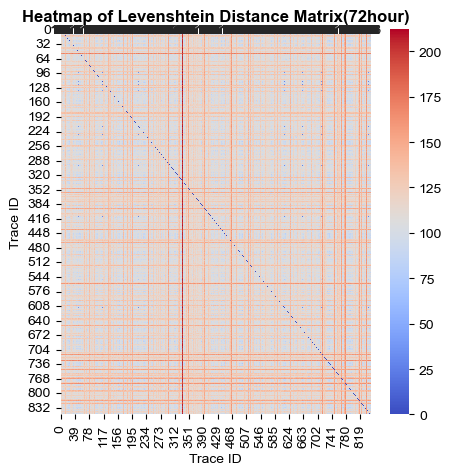

In [16]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(hamming_distance_matrix.astype(float), annot=True, cmap='coolwarm', fmt='g')

#plt.title('Heatmap of Levenshtein Distance Matrix(72hour)', fontsize=12, fontweight='bold')
plt.xlabel('Trace ID', fontsize=10)
plt.ylabel('Trace ID', fontsize=10)
plt.savefig('eFigure2_Heatmap of Levenshtein Distance Matrix(72hour).png', format='png', dpi=300)
plt.show()

In [17]:

levenshtein_row_averages = levenshtein_distance_matrix.mean(axis=1)

print("Levenshtein row averages:")
print(levenshtein_row_averages)

Levenshtein row averages:
0       92.11098
1      90.118064
2      94.257379
3      92.327037
4      90.658796
         ...    
842    99.885478
843    94.698937
844    86.577332
845    92.842975
846    87.284534
Length: 847, dtype: object


In [18]:
levenshtein_averages = levenshtein_row_averages.tolist()
levenshtein_averages = pd.DataFrame(levenshtein_row_averages, columns=['variation distance'])

print("Levenshtein averages:")
print(levenshtein_averages)

Levenshtein averages:
    variation distance
0             92.11098
1            90.118064
2            94.257379
3            92.327037
4            90.658796
..                 ...
842          99.885478
843          94.698937
844          86.577332
845          92.842975
846          87.284534

[847 rows x 1 columns]


In [19]:

levenshtein_sorted_row_averages = levenshtein_row_averages.sort_values(ascending=False)


levenshtein_reordered_matrix = levenshtein_distance_matrix.loc[levenshtein_sorted_row_averages.index]

print("Sorted row averages (descending):")
print(levenshtein_sorted_row_averages)

print("Reordered Levenshtein distance matrix:")
print(levenshtein_reordered_matrix)

Sorted row averages (descending):
333    160.713105
80     140.658796
395    135.736718
460    134.234947
52     134.190083
          ...    
488      84.20307
394     83.494687
734     82.735537
205     82.726092
497     82.367178
Length: 847, dtype: object
Reordered Levenshtein distance matrix:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  156  167  156  155  156  160  158  161  163  159  ...  158  156  161   
80   135  143  136  136  137  143  137  142  140  138  ...  138  137  140   
395  130  140  133  139  130  131  129  135  139  139  ...  133  132  136   
460  130  137  128  133  136  125  129  133  133  132  ...  129  130  132   
52   135  130  129  125  134  134  135  131  131  133  ...  127  128  136   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
488   84   76   92   85   71   89   95   75   68   86  ...   90   75   87   
394   79   77   91   77   83   83   89   67   67   88  ...   87   72   81   
734   77 

In [20]:
temp_distance = levenshtein_sorted_row_averages.reset_index(drop=True)

top_2_5_percentile = np.percentile(temp_distance, 97.5)
top_5_percentile = np.percentile(temp_distance, 95)
top_10_percentile = np.percentile(temp_distance, 90)
top_20_percentile = np.percentile(temp_distance, 80)
bottom_20_percentile = np.percentile(temp_distance, 20)

print(f"Top 2.5% of the list is above: {top_2_5_percentile}")
print(f"22 th: {levenshtein_sorted_row_averages[21]}")
print(f"Top 5% of the list is above: {top_5_percentile}")
print(f"Top 10% of the list is above: {top_10_percentile}")
print(f"Top 20% of the list is above: {top_20_percentile}")
print(f"Bottom 20% of the list is below: {bottom_20_percentile}")

Top 2.5% of the list is above: 118.83630460448643
22 th: 88.36363636363636
Top 5% of the list is above: 110.72680047225498
Top 10% of the list is above: 105.500826446281
Top 20% of the list is above: 99.75513577331759
Bottom 20% of the list is below: 88.49397874852421


In [21]:
if not levenshtein_sorted_row_averages.index.equals(hamming_sorted_row_averages.index):
    levenshtein_sorted_row_averages_positions = pd.Series(levenshtein_sorted_row_averages.index, name='levenshtein_sorted_row_averages_index')
    hamming_sorted_row_averages_positions = pd.Series(hamming_sorted_row_averages.index, name='hamming_sorted_row_averages_index')

    comparison_df = pd.DataFrame({'levenshtein_sorted_row_averages_position': levenshtein_sorted_row_averages_positions, 'hamming_sorted_row_averages_position': hamming_sorted_row_averages_positions})
    mismatched_positions = comparison_df[levenshtein_sorted_row_averages_positions != hamming_sorted_row_averages_positions]
    display(comparison_df)  
    print("Mismatched indexes and their positions:")
    display(mismatched_positions)  
else:
    print("Both DataFrames have the same index order.")

,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
0,333,333
1,80,80
2,395,460
3,460,395
4,52,52
...,...,...
842,488,340
843,394,148
844,734,563
845,205,627


Mismatched indexes and their positions:


,levenshtein_sorted_row_averages_position,hamming_sorted_row_averages_position
2,395,460
3,460,395
6,645,728
7,778,645
8,558,170
...,...,...
842,488,340
843,394,148
844,734,563
845,205,627


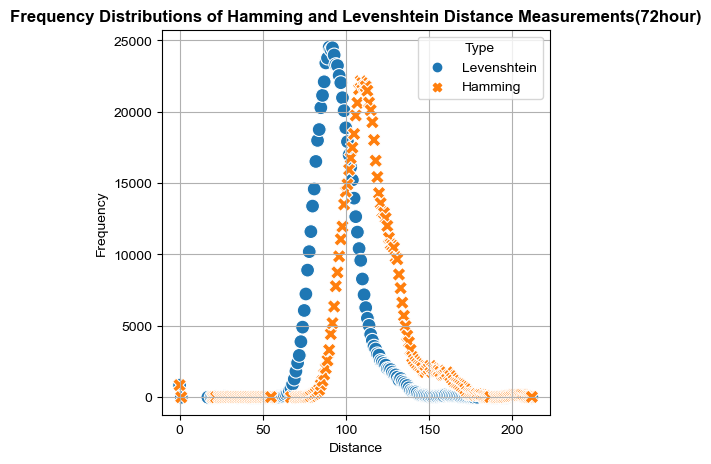

In [22]:
lev_distances = levenshtein_distance_matrix.values.flatten()
ham_distances = hamming_distance_matrix.values.flatten()

lev_unique_distances, lev_counts = np.unique(lev_distances, return_counts=True)
ham_unique_distances, ham_counts = np.unique(ham_distances, return_counts=True)

lev_distance_freq_df = pd.DataFrame({'Distance': lev_unique_distances, 'Frequency': lev_counts, 'Type': 'Levenshtein'})
ham_distance_freq_df = pd.DataFrame({'Distance': ham_unique_distances, 'Frequency': ham_counts, 'Type': 'Hamming'})

distance_freq_df = pd.concat([lev_distance_freq_df, ham_distance_freq_df])

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=distance_freq_df, x='Distance', y='Frequency', hue='Type', style='Type', s=100)

#plt.title('Frequency Distributions of Hamming and Levenshtein Distance Measurements(72hour)', fontsize=12, fontweight='bold')
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.savefig('eFigure3_Frequency Distributions of Hamming and Levenshtein Distance Measurements(72hour).png', bbox_inches='tight',format='png', dpi=300)
plt.grid(True)
plt.show()

In [23]:
#Select the top 2.5% and bottom 2.5% lists
top_2_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.025))
bottom_2_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.975))

top_2_percent_lists = levenshtein_reordered_matrix.iloc[:top_2_percent_index]
bottom_2_percent_lists = levenshtein_reordered_matrix.iloc[bottom_2_percent_index:]

In [24]:
# Select the top 5% and bottom 5% lists
top_5_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.05))
bottom_5_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.95))

top_5_percent_lists = levenshtein_reordered_matrix.iloc[:top_5_percent_index]
bottom_5_percent_lists = levenshtein_reordered_matrix.iloc[bottom_5_percent_index:]

In [25]:
# Select the top 10% and bottom 10% lists
top_10_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.10))
bottom_10_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.90))

top_10_percent_lists = levenshtein_reordered_matrix.iloc[:top_10_percent_index]
bottom_10_percent_lists = levenshtein_reordered_matrix.iloc[bottom_10_percent_index:]

In [26]:
# Select the top 20% and bottom 20% lists
top_20_percent_index = int(np.ceil(len(levenshtein_sorted_row_averages) * 0.20))
bottom_20_percent_index = int(np.floor(len(levenshtein_sorted_row_averages) * 0.80))

top_20_percent_lists = levenshtein_reordered_matrix.iloc[:top_20_percent_index]
bottom_20_percent_lists = levenshtein_reordered_matrix.iloc[bottom_20_percent_index:]

In [27]:
print("Top 2.5% lists:")
print(top_2_percent_lists)
print("Bottom 2.5% lists:")
print(bottom_2_percent_lists)

top_2_percent_index = top_2_percent_lists.index.tolist()
print("PatientID of Top 2.5% traces:")
print(top_2_percent_lists.index.tolist())
bottom_2_percent_index = bottom_2_percent_lists.index.tolist()
print("PatientID of Bottom 2.5% traces:")
print(bottom_2_percent_lists.index.tolist())

Top 2.5% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  156  167  156  155  156  160  158  161  163  159  ...  158  156  161   
80   135  143  136  136  137  143  137  142  140  138  ...  138  137  140   
395  130  140  133  139  130  131  129  135  139  139  ...  133  132  136   
460  130  137  128  133  136  125  129  133  133  132  ...  129  130  132   
52   135  130  129  125  134  134  135  131  131  133  ...  127  128  136   
416  128  130  125  139  132  134  130  129  130  131  ...  131  126  131   
645  121  135  124  130  133  130  132  127  126  128  ...  128  126  133   
778  125  130  122  128  126  125  121  124  127  121  ...  118  119  128   
558  126  133  119  126  119  127  125  123  123  126  ...  121  126  126   
728  116  130  123  127  121  130  130  130  126  124  ...  128  122  132   
170  118  127  126  123  125  122  123  130  127  131  ...  125  126  126   
715  125  126  121  122  118  128  124  124  120  118  ...  

In [28]:
complete_patients_clinical = pd.read_csv('completepatients.csv')
complete_patients = pd.concat([complete_patients_clinical,levenshtein_averages], axis=1)
print(complete_patients.head())

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  \
0         SINGLE                   1                         1  ...   
1        MARRIED                   0                         0  ...   
2        MARRIED                   0                         0  ...   
3        MARRIED                   0                         0  ...   
4        MARRIED                   1                         0  ...   

   renal_disease  malignant_cancer  severe_liver_disease  \
0              0                 0          

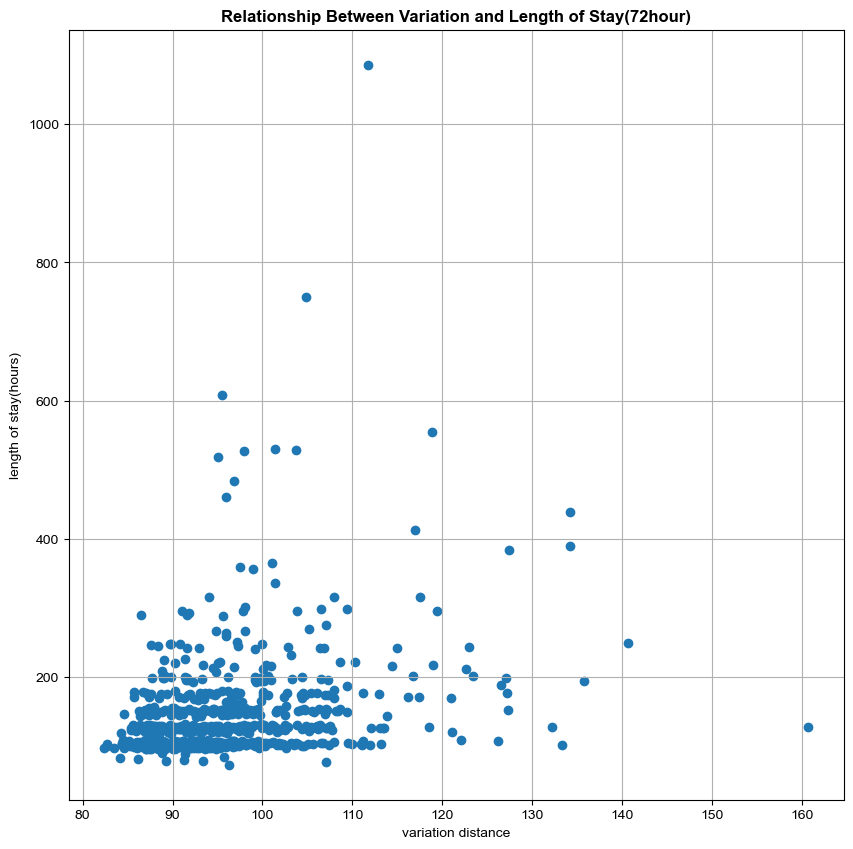

In [29]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10 
})

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(complete_patients['variation distance'],complete_patients['length_of_stay'])

#plt.title('Relationship Between Variation and Length of Stay(72hour)', fontsize=12, fontweight='bold')
plt.xlabel('variation distance', fontsize=10)
plt.ylabel('length of stay(hours)', fontsize=10)
plt.savefig('Figure_Relationship Between Variation and Length of Stay(72hour).png', bbox_inches='tight',format='png', dpi=800)
plt.grid(True)
plt.show()

In [30]:
#print(complete_patients.dtypes)
complete_patients['distance'] = pd.to_numeric(complete_patients['variation distance'], errors='coerce')

In [31]:
complete_patients['age_group'] = pd.cut(complete_patients['age'], bins=[20, 30, 40, 50, 60, 70, 80, 90, 100],
                         labels=['20-30', '31-40', '41-50', '51-60', '61-70','71-80','81-90','91-100'])

In [32]:
def categorize_cci(cci):
    if 10 <= cci <= 12:
        return '10-12'
    elif 8 <= cci < 10:
        return '8-10'
    elif 6 <= cci < 8:
        return '6-8'
    elif 4 <= cci < 6:  
        return '4-6'
    elif 2 <= cci < 4:  
        return '2-4'
    elif 0 <= cci < 2:
        return '0-2'
complete_patients['cci_group'] = complete_patients['cci'].apply(categorize_cci)

In [33]:
'''
def categorize_distance(distance):
    if distance >= 118:
        return 'top2.5%'
    elif distance >= 110:
        return 'top5%'
    elif distance >= 105:
        return 'top10%'
    elif distance >= 99:  
        return 'top20%'
    elif 88 < distance < 99:  
        return 'middle value'
    elif distance <= 88:  
        return 'bottom20%'
'''
def categorize_distance(distance):
    if distance >= 99:  
        return 'top20%'
    else:  
        return 'Other'
complete_patients['distance_group'] = complete_patients['distance'].apply(categorize_distance)

In [34]:
print(complete_patients.head())
#complete_patients.to_csv('test.csv',index = False)
value_counts = complete_patients['distance_group'].value_counts()
print(value_counts)

   subject_id   hadm_id  age gender insurance language                race  \
0    10002013  23581541   57      F  Medicare  ENGLISH               OTHER   
1    10011398  27505812   67      M     Other  ENGLISH  HISPANIC OR LATINO   
2    10023771  20044587   70      M  Medicare  ENGLISH               WHITE   
3    10033786  27383470   50      M     Other  ENGLISH               WHITE   
4    10039688  26345871   63      F  Medicare  ENGLISH               WHITE   

  marital_status  myocardial_infarct  congestive_heart_failure  ...  aids  \
0         SINGLE                   1                         1  ...     0   
1        MARRIED                   0                         0  ...     0   
2        MARRIED                   0                         0  ...     0   
3        MARRIED                   0                         0  ...     0   
4        MARRIED                   1                         0  ...     0   

   cci  in_hospital_mortality  died_within_30_days  length_of_stay  

In [35]:
complete_patients['race'] = complete_patients['race'].str.split(' ').str[0]
complete_patients['race']= complete_patients['race'].replace(['BLACK/AFRICAN', 'BLACK/CARIBBEAN','BLACK/CAPE','HISPANIC/LATINO','HISPANIC','PATIENT', 'UNABLE','SOUTH','PORTUGUESE','MULTIPLE','OTHER','ASIAN','UNKNOWN'], 'OTHER')
value_counts_race = complete_patients['race'].value_counts()
print(value_counts_race)

race
WHITE    667
OTHER    180
Name: count, dtype: int64


In [36]:
value_counts_gender = complete_patients['gender'].value_counts()
print(value_counts_gender)
value_counts_insurance = complete_patients['insurance'].value_counts()
print(value_counts_insurance)

gender
M    701
F    146
Name: count, dtype: int64
insurance
Other       506
Medicare    313
Medicaid     28
Name: count, dtype: int64


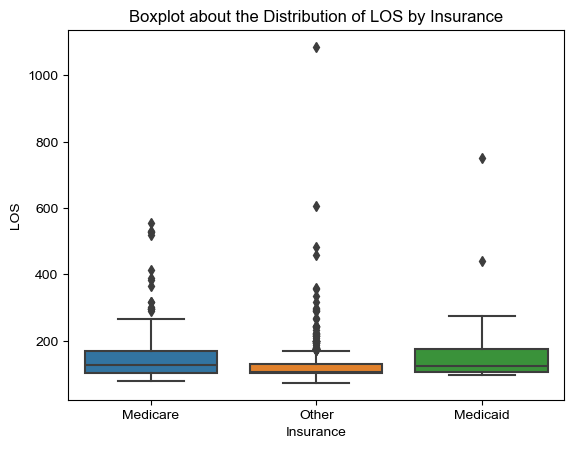

In [37]:
sns.boxplot(x='insurance', y='length_of_stay', data=complete_patients[['insurance','length_of_stay']])
plt.title('Boxplot about the Distribution of LOS by Insurance')
plt.xlabel('Insurance')
plt.ylabel('LOS')
plt.show()

In [38]:
import statsmodels.formula.api as smf
y = complete_patients['length_of_stay']
model = smf.ols('y ~ distance_group + age + cci + C(gender) + C(insurance) + C(race)', data=complete_patients).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     19.13
Date:                Thu, 06 Feb 2025   Prob (F-statistic):           8.43e-24
Time:                        16:43:05   Log-Likelihood:                -4771.9
No. Observations:                 847   AIC:                             9560.
Df Residuals:                     839   BIC:                             9598.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [39]:
print(complete_patients.columns)

Index(['subject_id', 'hadm_id', 'age', 'gender', 'insurance', 'language',
       'race', 'marital_status', 'myocardial_infarct',
       'congestive_heart_failure', 'peripheral_vascular_disease',
       'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
       'rheumatic_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
       'diabetes_without_cc', 'diabetes_with_cc', 'paraplegia',
       'renal_disease', 'malignant_cancer', 'severe_liver_disease',
       'metastatic_solid_tumor', 'aids', 'cci', 'in_hospital_mortality',
       'died_within_30_days', 'length_of_stay', 'variation distance',
       'distance', 'age_group', 'cci_group', 'distance_group'],
      dtype='object')


In [40]:
top_2_percent = complete_patients.loc[top_2_percent_index]
print(top_2_percent)
output_path = 'top_2_percent.csv'
top_2_percent.to_csv(output_path, index=False)
top_2_percent_los = top_2_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_2_percent_los}")
top_2_percent_in_hospital_mortality = top_2_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_2_percent_in_hospital_mortality}")
top_2_percent_30_day_mortality = top_2_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_2_percent_30_day_mortality}")
top_2_percent_cci =top_2_percent['cci'].mean()
print(f"The average of CCI is: {top_2_percent_cci}")
top_2_percent_top3cci_averages = top_2_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_2_percent_top3cci = top_2_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_2_percent_top3cci)

     subject_id   hadm_id  age gender insurance language   race  \
333    14195255  27013153   74      M  Medicare  ENGLISH  WHITE   
80     11076206  20326682   63      F  Medicare  ENGLISH  WHITE   
395    14908025  23478116   60      M     Other  ENGLISH  OTHER   
460    15610823  26657269   69      F  Medicare  ENGLISH  WHITE   
52     10710573  29923776   55      M  Medicaid        ?  OTHER   
416    15156174  27191368   51      M     Other  ENGLISH  WHITE   
645    17641873  21705480   81      M     Other  ENGLISH  WHITE   
778    19359798  25190591   72      M  Medicare  ENGLISH  WHITE   
558    16688809  25787655   74      M     Other  ENGLISH  WHITE   
728    18669132  21506797   40      M     Other  ENGLISH  OTHER   
170    12253915  28119979   79      M  Medicare  ENGLISH  WHITE   
715    18477527  24209714   79      M     Other  ENGLISH  WHITE   
467    15708357  20482084   52      M  Medicare  ENGLISH  WHITE   
816    19674244  28712211   55      M     Other  ENGLISH  WHIT

In [41]:
# Display the top 5% lists
print("Top 5% lists:")
print(top_5_percent_lists)

# Display the bottom 5% lists
print("Bottom 5% lists:")
print(bottom_5_percent_lists)

top_5_percent_index = top_5_percent_lists.index.tolist()
print("PatientID of Top 5% traces:")
print(top_5_percent_lists.index.tolist())
bottom_5_percent_index = bottom_5_percent_lists.index.tolist()
print("PatientID of Bottom 5% traces:")
print(bottom_5_percent_lists.index.tolist())

Top 5% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  156  167  156  155  156  160  158  161  163  159  ...  158  156  161   
80   135  143  136  136  137  143  137  142  140  138  ...  138  137  140   
395  130  140  133  139  130  131  129  135  139  139  ...  133  132  136   
460  130  137  128  133  136  125  129  133  133  132  ...  129  130  132   
52   135  130  129  125  134  134  135  131  131  133  ...  127  128  136   
416  128  130  125  139  132  134  130  129  130  131  ...  131  126  131   
645  121  135  124  130  133  130  132  127  126  128  ...  128  126  133   
778  125  130  122  128  126  125  121  124  127  121  ...  118  119  128   
558  126  133  119  126  119  127  125  123  123  126  ...  121  126  126   
728  116  130  123  127  121  130  130  130  126  124  ...  128  122  132   
170  118  127  126  123  125  122  123  130  127  131  ...  125  126  126   
715  125  126  121  122  118  128  124  124  120  118  ...  12

In [42]:
# Display the top 10% lists
print("Top 10% lists:")
print(top_10_percent_lists)

# Display the bottom 10% lists
print("Bottom 10% lists:")
print(bottom_10_percent_lists)

top_10_percent_index = top_10_percent_lists.index.tolist()
print("PatientID of Top 10% traces:")
print(top_10_percent_lists.index.tolist())
bottom_10_percent_index = bottom_10_percent_lists.index.tolist()
print("PatientID of Bottom 10% traces:")
print(bottom_10_percent_lists.index.tolist())

Top 10% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  156  167  156  155  156  160  158  161  163  159  ...  158  156  161   
80   135  143  136  136  137  143  137  142  140  138  ...  138  137  140   
395  130  140  133  139  130  131  129  135  139  139  ...  133  132  136   
460  130  137  128  133  136  125  129  133  133  132  ...  129  130  132   
52   135  130  129  125  134  134  135  131  131  133  ...  127  128  136   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
255  100  110   97  102  102  101  102  101  101  106  ...   99  101  103   
331   95  106  102   98  101  104  101  100  100  102  ...  101  100  106   
273  107   98  104  104  108  103  105   98   98  105  ...  103  100  100   
56   105  104  101  107  102  110  108  102  101  102  ...   95  101  108   
191  102  105  102  105  109   97   97   98  105  103  ...  105  102   99   

     840  841  842  843  844  845  846  
333  160  188  161 

In [43]:
# Display the top 20% lists
print("Top 20% lists:")
print(top_20_percent_lists)

# Display the bottom 20% lists
print("Bottom 20% lists:")
print(bottom_20_percent_lists)

top_20_percent_index = top_20_percent_lists.index.tolist()
print("PatientID of Top 20% traces:")
print(top_20_percent_lists.index.tolist())
bottom_20_percent_index = bottom_20_percent_lists.index.tolist()
print("PatientID of Bottom 20% traces:")
print(bottom_20_percent_lists.index.tolist())

Top 20% lists:
     0    1    2    3    4    5    6    7    8    9    ...  837  838  839  \
333  156  167  156  155  156  160  158  161  163  159  ...  158  156  161   
80   135  143  136  136  137  143  137  142  140  138  ...  138  137  140   
395  130  140  133  139  130  131  129  135  139  139  ...  133  132  136   
460  130  137  128  133  136  125  129  133  133  132  ...  129  130  132   
52   135  130  129  125  134  134  135  131  131  133  ...  127  128  136   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
769   95   92  101   99   97  104  100   93   90  101  ...  107   91   93   
842   93   93  102   90   98   87   91   93   89   99  ...  102   96   90   
574   99  103  104  101   97  104  100   96   95  109  ...  103   94  100   
368   98   94  102   96   99  104  100   93   90  102  ...   97   95   97   
296   98   99   95   98   85  100  101   92   95   97  ...  102   93  104   

     840  841  842  843  844  845  846  
333  160  188  161 

In [44]:
top_5_percent = complete_patients.loc[top_5_percent_index]
output_path = 'top_5_percent.csv'
top_5_percent.to_csv(output_path, index=False)
top_5_percent_los = top_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_5_percent_los}")
top_5_percent_in_hospital_mortality = top_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_5_percent_in_hospital_mortality}")
top_5_percent_30_day_mortality = top_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_5_percent_30_day_mortality}")
top_5_percent_cci =top_5_percent['cci'].mean()
print(f"The average of CCI is: {top_5_percent_cci}")
top_5_percent_top3cci_averages = top_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_5_percent_top3cci = top_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_5_percent_top3cci)

The average of LOS is: 219.05736434108528
The average of in_hospital_mortality is: 0.06976744186046512
The average of 30_day_mortality is: 0.06976744186046512
The average of CCI is: 5.232558139534884
Top3 CCI:
renal_disease               0.441860
congestive_heart_failure    0.348837
diabetes_without_cc         0.348837
dtype: float64


In [45]:
top_10_percent = complete_patients.loc[top_10_percent_index]
output_path = 'top_10_percent.csv'
top_10_percent.to_csv(output_path, index=False)
top_10_percent_los = top_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_10_percent_los}")
top_10_percent_in_hospital_mortality = top_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_10_percent_in_hospital_mortality}")
top_10_percent_30_day_mortality = top_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_10_percent_30_day_mortality}")
top_10_percent_cci =top_10_percent['cci'].mean()
print(f"The average of CCI is: {top_10_percent_cci}")
top_10_percent_top3cci_averages = top_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_10_percent_top3cci = top_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_10_percent_top3cci)

The average of LOS is: 192.0190196078431
The average of in_hospital_mortality is: 0.047058823529411764
The average of 30_day_mortality is: 0.047058823529411764
The average of CCI is: 4.741176470588235
Top3 CCI:
diabetes_without_cc          0.423529
congestive_heart_failure     0.294118
chronic_pulmonary_disease    0.282353
dtype: float64


In [46]:
top_20_percent = complete_patients.loc[top_20_percent_index]
output_path = 'top_20_percent.csv'
top_20_percent.to_csv(output_path, index=False)
top_20_percent_los = top_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {top_20_percent_los}")
top_20_percent_in_hospital_mortality = top_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {top_20_percent_in_hospital_mortality}")
top_20_percent_30_day_mortality = top_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {top_20_percent_30_day_mortality}")
top_20_percent_cci =top_20_percent['cci'].mean()
print(f"The average of CCI is: {top_20_percent_cci}")
top_20_percent_top3cci_averages = top_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
top_20_percent_top3cci = top_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(top_20_percent_top3cci)

The average of LOS is: 179.02921568627448
The average of in_hospital_mortality is: 0.023529411764705882
The average of 30_day_mortality is: 0.023529411764705882
The average of CCI is: 4.617647058823529
Top3 CCI:
diabetes_without_cc    0.382353
myocardial_infarct     0.311765
renal_disease          0.264706
dtype: float64


In [47]:
bottom_5_percent = complete_patients.loc[bottom_5_percent_index]
output_path = 'bottom_5_percent.csv'
bottom_5_percent.to_csv(output_path, index=False)
bottom_5_percent_los = bottom_5_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_5_percent_los}")
bottom_5_percent_in_hospital_mortality = bottom_5_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_5_percent_in_hospital_mortality}")
bottom_5_percent_30_day_mortality = bottom_5_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_5_percent_30_day_mortality}")
bottom_5_percent_cci =bottom_5_percent['cci'].mean()
print(f"The average of CCI is: {bottom_5_percent_cci}")

bottom_5_percent_top3cci_averages = bottom_5_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_5_percent_top3cci = bottom_5_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_5_percent_top3cci)

The average of LOS is: 110.42751937984498
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 2.8372093023255816
Top3 CCI:
myocardial_infarct           0.209302
diabetes_without_cc          0.209302
chronic_pulmonary_disease    0.139535
dtype: float64


In [48]:
bottom_10_percent = complete_patients.loc[bottom_10_percent_index]
output_path = 'bottom_10_percent.csv'
bottom_10_percent.to_csv(output_path, index=False)
bottom_10_percent_los = bottom_10_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_10_percent_los}")
bottom_10_percent_in_hospital_mortality = bottom_10_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_10_percent_in_hospital_mortality}")
bottom_10_percent_30_day_mortality = bottom_10_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_10_percent_30_day_mortality}")
bottom_10_percent_cci =bottom_10_percent['cci'].mean()
print(f"The average of CCI is: {bottom_10_percent_cci}")

bottom_10_percent_top3cci_averages = bottom_10_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_10_percent_top3cci = bottom_10_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_10_percent_top3cci)

The average of LOS is: 115.67588235294116
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.164705882352941
Top3 CCI:
diabetes_without_cc         0.282353
myocardial_infarct          0.200000
congestive_heart_failure    0.117647
dtype: float64


In [49]:
bottom_20_percent = complete_patients.loc[bottom_20_percent_index]
output_path = 'bottom_20_percent.csv'
bottom_20_percent.to_csv(output_path, index=False)
bottom_20_percent_los = bottom_20_percent['length_of_stay'].mean()
print(f"The average of LOS is: {bottom_20_percent_los}")
bottom_20_percent_in_hospital_mortality = bottom_20_percent['in_hospital_mortality'].mean()
print(f"The average of in_hospital_mortality is: {bottom_20_percent_in_hospital_mortality}")
bottom_20_percent_30_day_mortality = bottom_20_percent['died_within_30_days'].mean()
print(f"The average of 30_day_mortality is: {bottom_20_percent_30_day_mortality}")
bottom_20_percent_cci =bottom_20_percent['cci'].mean()
print(f"The average of CCI is: {bottom_20_percent_cci}")

bottom_20_percent_top3cci_averages = bottom_20_percent[['myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']].mean()
bottom_20_percent_top3cci = bottom_20_percent_top3cci_averages.nlargest(3)
print("Top3 CCI:")
print(bottom_20_percent_top3cci)

The average of LOS is: 117.79627450980391
The average of in_hospital_mortality is: 0.0
The average of 30_day_mortality is: 0.0
The average of CCI is: 3.2941176470588234
Top3 CCI:
diabetes_without_cc          0.300000
myocardial_infarct           0.205882
chronic_pulmonary_disease    0.111765
dtype: float64


In [50]:
#X = complete_patients[['age','cci','myocardial_infarct', 'congestive_heart_failure', 'peripheral_vascular_disease', 'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease', 'rheumatic_disease','peptic_ulcer_disease','mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer','severe_liver_disease','metastatic_solid_tumor','aids']]

In [51]:
traces_top_2_percent = traces.iloc[top_2_percent_index]
top_2_percent_patient = traces_top_2_percent['patientid']
print(top_2_percent_patient)
events_final_top_2_percent = events_final[events_final['patientid'].isin(top_2_percent_patient)]
print(events_final_top_2_percent)
events_final_top_2_percent.to_csv('events_final_top_2_percent.csv', index=False)

333    14195255
80     11076206
395    14908025
460    15610823
52     10710573
416    15156174
645    17641873
778    19359798
558    16688809
728    18669132
170    12253915
715    18477527
467    15708357
816    19674244
748    18942549
835    19872834
364    14603993
100    11318805
358    14546527
240    13139482
295    13801654
767    19177655
Name: patientid, dtype: int64
       patientid       events           starttime
5818    10710573        CSURG 2114-04-17 01:33:36
5819    10710573          ABG 2114-04-17 08:26:00
5820    10710573          CBC 2114-04-17 08:26:00
5821    10710573      Glucose 2114-04-17 08:26:00
5822    10710573      Calcium 2114-04-17 08:26:00
...          ...          ...                 ...
95129   19872834  5% Dextrose 2139-06-06 14:00:00
95130   19872834     Diuretic 2139-06-06 14:00:00
95131   19872834   Amiodarone 2139-06-06 14:00:00
95132   19872834          ABG 2139-06-06 14:10:00
95133   19872834      Calcium 2139-06-06 14:10:00

[3727 rows x 3 co

In [52]:
traces_top_5_percent = traces.iloc[top_5_percent_index]
top_5_percent_patient = traces_top_5_percent['patientid']
print(top_5_percent_patient)
events_final_top_5_percent = events_final[events_final['patientid'].isin(top_5_percent_patient)]
print(events_final_top_5_percent)
events_final_top_5_percent.to_csv('events_final_top_5_percent.csv', index=False)

333    14195255
80     11076206
395    14908025
460    15610823
52     10710573
416    15156174
645    17641873
778    19359798
558    16688809
728    18669132
170    12253915
715    18477527
467    15708357
816    19674244
748    18942549
835    19872834
364    14603993
100    11318805
358    14546527
240    13139482
295    13801654
767    19177655
393    14877104
651    17672672
468    15737972
349    14369707
440    15417736
513    16199860
196    12585231
421    15183187
131    11777223
94     11162509
804    19559236
619    17378719
299    13963514
775    19302735
79     11047016
454    15566276
822    19723798
263    13424432
628    17466817
214    12782295
184    12445879
Name: patientid, dtype: int64
       patientid       events           starttime
5818    10710573        CSURG 2114-04-17 01:33:36
5819    10710573          ABG 2114-04-17 08:26:00
5820    10710573          CBC 2114-04-17 08:26:00
5821    10710573      Glucose 2114-04-17 08:26:00
5822    10710573      Calcium 21

In [53]:
traces_bottom_20_percent = traces.iloc[bottom_20_percent_index]
bottom_20_percent_patient = traces_bottom_20_percent['patientid']
print(bottom_20_percent_patient)
events_final_bottom_20_percent = events_final[events_final['patientid'].isin(bottom_20_percent_patient)]
print(events_final_bottom_20_percent)
events_final_bottom_20_percent.to_csv('events_final_bottom_20_percent.csv', index=False)

503    16092524
291    13773889
452    15530386
259    13378790
744    18907241
         ...   
488    15923751
394    14884188
734    18716421
205    12676102
497    16019747
Name: patientid, Length: 170, dtype: int64
       patientid             events           starttime
809     10055828              CSURG 2146-11-30 02:28:47
810     10055828            Aspirin 2146-11-30 10:00:00
811     10055828                ABG 2146-11-30 10:24:00
812     10055828            Calcium 2146-11-30 10:24:00
813     10055828            Glucose 2146-11-30 10:24:00
...          ...                ...                 ...
96243   19995790         Creatinine 2185-02-04 04:45:00
96244   19995790            Glucose 2185-02-04 04:45:00
96245   19995790         Metoprolol 2185-02-04 20:00:00
96246   19995790                 SW 2185-02-05 01:00:00
96247   19995790  Magnesium Sulfate 2185-02-05 01:00:00

[16888 rows x 3 columns]
